In [1]:
# %pip install pandas scikit-learn matplotlib numpy
# %pip install tensorflow[and-cuda]

In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
from random import shuffle

from model_creation import create_cnn_lstm_model, create_cnn_gru_model


In [3]:
data_full = pd.read_csv("data_full.csv", header=0)
data_full['DATE (MM/DD/YYYY)'] = pd.to_datetime(data_full['DATE (MM/DD/YYYY)'], format='%Y-%m-%d %H:%M:%S')
data_full.set_index('DATE (MM/DD/YYYY)', inplace=True)

# Resample data to 1-hour intervals using mean
data_full = data_full.resample('1h').mean()
data_full.drop(columns=[
    'Global CMP22 (vent/cor) [W/m^2]',
    'Global CM6b (cor) [W/m^2]',
    'Global CM3 (cor) [W/m^2]',
    'Global PSP (vent/cor) [W/m^2]',
    'Global LI-200 [W/m^2]',
    'Global TSP-700 Vent [W/m^2]',
    'Global SP Lite2 [W/m^2]',
    'Global SP-110 [W/m^2]',
    # 'Tower Wet Bulb Temp [deg C]',
    # 'Total Cloud Cover [%]',
    # 'Direct Extraterrestrial (calc) [W/m^2]',
    # 'Tower Wind Chill Temp [deg C]'
], inplace=True)

print("Original data shape:", data_full.shape)
print("Hourly data shape:", data_full.shape)
data_full.head()

data_full

Original data shape: (96408, 18)
Hourly data shape: (96408, 18)


,Zenith Angle [degrees],Azimuth Angle [degrees],Airmass,Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower Wind Chill Temp [deg C],Tower RH [%],Total Cloud Cover [%],Opaque Cloud Cover [%],Avg Wind Speed @ 19ft [m/s],Peak Wind Speed @ 19ft [m/s],Avg Wind Direction @ 19ft [deg from N],Vertical Wind Shear [1/s],Station Pressure [mBar],Global Extraterrestrial (calc) [W/m^2],Direct Extraterrestrial (calc) [W/m^2],GHI Mean
DATE (MM/DD/YYYY),,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,162.061916,48.851776,0.0,-10.217333,-10.788450,-12.201783,-10.372317,83.714167,0.0,0.0,1.276650,1.473333,294.553000,0.005283,814.118900,0.0,0.0,0.0
2013-01-01 01:00:00,155.260928,52.772045,0.0,-9.942333,-10.770533,-12.917200,-12.229850,76.558833,0.0,0.0,1.851000,2.208333,287.896667,0.054000,814.277883,0.0,0.0,0.0
2013-01-01 02:00:00,145.059934,71.999074,0.0,-9.289833,-10.406217,-13.334550,-13.633083,69.566667,0.0,0.0,2.900233,3.491667,303.628333,0.111117,814.736583,0.0,0.0,0.0
2013-01-01 03:00:00,133.800905,84.478356,0.0,-9.421500,-10.295600,-12.518933,-10.072533,75.850500,0.0,0.0,1.759433,2.195833,307.818417,0.083033,815.411833,0.0,0.0,0.0
2013-01-01 04:00:00,122.297441,94.248839,0.0,-9.732167,-10.445833,-12.234167,-10.808300,79.957000,0.0,0.0,1.278550,1.654167,178.474267,0.032700,815.824267,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,120.584151,264.280572,0.0,-0.305350,-2.612400,-6.035733,-0.362133,61.720167,0.0,0.0,0.873817,1.358333,33.620367,0.086283,818.427750,0.0,0.0,0.0
2023-12-31 20:00:00,132.083604,273.811519,0.0,-0.962350,-2.989533,-6.019533,-0.962350,65.196167,0.0,0.0,0.336817,0.700000,150.711667,0.014883,818.463050,0.0,0.0,0.0
2023-12-31 21:00:00,143.414297,285.688949,0.0,-1.150100,-3.071867,-5.980200,-1.150100,66.442667,0.0,0.0,0.697667,0.970833,302.268700,0.000100,818.509700,0.0,0.0,0.0


In [4]:
def bad_correlation_with_output(dataset, threshold):
   col_corr = set()  # Set of all the names of correlated columns
   corr_matrix = dataset.corr(method='spearman')  # Calculate Spearman correlation
   num_columns = len(corr_matrix.columns) 
   for i in range(num_columns):
      if i != 0:
         if abs(corr_matrix.iloc[i,17 ]) < threshold:
               colname = corr_matrix.columns[i]
               col_corr.add(colname)
   return col_corr

bad_features = bad_correlation_with_output(data_full, 0.2)
data_full.drop(columns=bad_features, inplace=True)
data_full


,Zenith Angle [degrees],Airmass,Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Wind Chill Temp [deg C],Tower RH [%],Total Cloud Cover [%],Opaque Cloud Cover [%],Avg Wind Direction @ 19ft [deg from N],Global Extraterrestrial (calc) [W/m^2],Direct Extraterrestrial (calc) [W/m^2],GHI Mean
DATE (MM/DD/YYYY),,,,,,,,,,,,
2013-01-01 00:00:00,162.061916,0.0,-10.217333,-10.788450,-10.372317,83.714167,0.0,0.0,294.553000,0.0,0.0,0.0
2013-01-01 01:00:00,155.260928,0.0,-9.942333,-10.770533,-12.229850,76.558833,0.0,0.0,287.896667,0.0,0.0,0.0
2013-01-01 02:00:00,145.059934,0.0,-9.289833,-10.406217,-13.633083,69.566667,0.0,0.0,303.628333,0.0,0.0,0.0
2013-01-01 03:00:00,133.800905,0.0,-9.421500,-10.295600,-10.072533,75.850500,0.0,0.0,307.818417,0.0,0.0,0.0
2013-01-01 04:00:00,122.297441,0.0,-9.732167,-10.445833,-10.808300,79.957000,0.0,0.0,178.474267,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,120.584151,0.0,-0.305350,-2.612400,-0.362133,61.720167,0.0,0.0,33.620367,0.0,0.0,0.0
2023-12-31 20:00:00,132.083604,0.0,-0.962350,-2.989533,-0.962350,65.196167,0.0,0.0,150.711667,0.0,0.0,0.0
2023-12-31 21:00:00,143.414297,0.0,-1.150100,-3.071867,-1.150100,66.442667,0.0,0.0,302.268700,0.0,0.0,0.0


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data_full.to_numpy())
data = pd.DataFrame(data, columns=list(data_full.columns))

data


,Zenith Angle [degrees],Airmass,Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Wind Chill Temp [deg C],Tower RH [%],Total Cloud Cover [%],Opaque Cloud Cover [%],Avg Wind Direction @ 19ft [deg from N],Global Extraterrestrial (calc) [W/m^2],Direct Extraterrestrial (calc) [W/m^2],GHI Mean
0,0.998386,0.0,0.243027,0.329259,0.295364,0.668347,0.0,0.0,0.818025,0.0,0.0,0.0
1,0.951385,0.0,0.247419,0.329655,0.267839,0.609294,0.0,0.0,0.799517,0.0,0.0,0.0
2,0.880887,0.0,0.257840,0.337691,0.247046,0.551588,0.0,0.0,0.843259,0.0,0.0,0.0
3,0.803078,0.0,0.255738,0.340131,0.299806,0.603448,0.0,0.0,0.854910,0.0,0.0,0.0
4,0.723579,0.0,0.250776,0.336817,0.288904,0.637339,0.0,0.0,0.495270,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
96403,0.711739,0.0,0.401330,0.509611,0.443696,0.486831,0.0,0.0,0.092505,0.0,0.0,0.0
96404,0.791210,0.0,0.390837,0.501292,0.434802,0.515518,0.0,0.0,0.418076,0.0,0.0,0.0
96405,0.869515,0.0,0.387838,0.499476,0.432020,0.525806,0.0,0.0,0.839479,0.0,0.0,0.0
96406,0.941812,0.0,0.396782,0.507094,0.440318,0.505057,0.0,0.0,0.855859,0.0,0.0,0.0


In [25]:
def singleStepSampler(df, window):
    # Convert DataFrame to numpy array for faster operations
    data = df.values
    n = len(data)
    
    # Create sliding windows using array indexing
    x = np.array([data[i:i+window] for i in range(n - window)])
    
    # Get the target values (GHI Mean is the first column)
    y = data[window:, 11]  # Assuming 'GHI Mean' is the first column
    
    return x, y.reshape(-1, 1)  # Reshape y to be 2D (n_samples, 1)

(xVal, yVal) = singleStepSampler(data, 24)

In [27]:
SPLIT = 0.8

train_threshold = int(SPLIT * len(xVal))
val_threshold = int((1 - (1 - SPLIT) / 2) * len(xVal))

X_train = xVal[:train_threshold]
Y_train = yVal[:train_threshold]
X_val = xVal[train_threshold:val_threshold]
Y_val = yVal[train_threshold:val_threshold]
X_test = xVal[val_threshold:]
Y_test = yVal[val_threshold:]

# Output the size of the dataset
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (77107, 24, 12)
Y_train shape: (77107, 1)
X_val shape: (9638, 24, 12)
Y_val shape: (9638, 1)
X_test shape: (9639, 24, 12)
Y_test shape: (9639, 1)


In [28]:
# Determine input shape and number of features
input_shape = (X_train.shape[1], X_train.shape[2])

# Compile the model
model_cnn_gru = create_cnn_gru_model(input_shape)
optimizer = Adam(learning_rate=0.001)
model_cnn_gru.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model_cnn_gru.summary()

# Train the model
history = model_cnn_gru.fit(
   X_train, Y_train,
   validation_data=(X_val, Y_val),
   epochs=60,
   verbose=1
)

# Save model architecture
model_cnn_gru.save('model_cnn_gru.keras')
with open("model_cnn_gru.json", "w") as json_file:
   json_file.write(model_cnn_gru.to_json())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 24, 64)         │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 6, 128)         │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 6, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,737 (643.50 KB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/60
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - loss: 0.0685 - mae: 0.1697 - val_loss: 0.0050 - val_mae: 0.0482
Epoch 2/60
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 0.0062 - mae: 0.0506 - val_loss: 0.0041 - val_mae: 0.0386
Epoch 3/60
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0056 - mae: 0.0472 - val_loss: 0.0039 - val_mae: 0.0362
Epoch 4/60
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0053 - mae: 0.0453 - val_loss: 0.0037 - val_mae: 0.0367
Epoch 5/60
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0051 - mae: 0.0435 - val_loss: 0.0043 - val_mae: 0.0403
Epoch 6/60
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0049 - mae: 0.0426 - val_loss: 0.0037 - val_mae: 0.0337
Epoch 7/60
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.0050 - mae: 0.0424 - val_loss: 0.0033 - val_mae: 0.0272
Epoch 8/60
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.0048 - mae: 0.0414 - val_loss: 0.0038 - val_mae: 0.0326
Epoch 9/60
2410/2410 ━━━━━━━

In [29]:
# Import the created model
model = model_cnn_gru

# Test the model on the test set
test_loss, test_mae = model.evaluate(X_test, Y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Make predictions on test data
Y_pred = model.predict(X_test)

# Calculate additional metrics
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"\nTest Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0025 - mae: 0.0240
Test Loss: 0.0033
Test MAE: 0.0272
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Test Metrics:
RMSE: 0.0570
MAE: 0.0272
R² Score: 0.9412


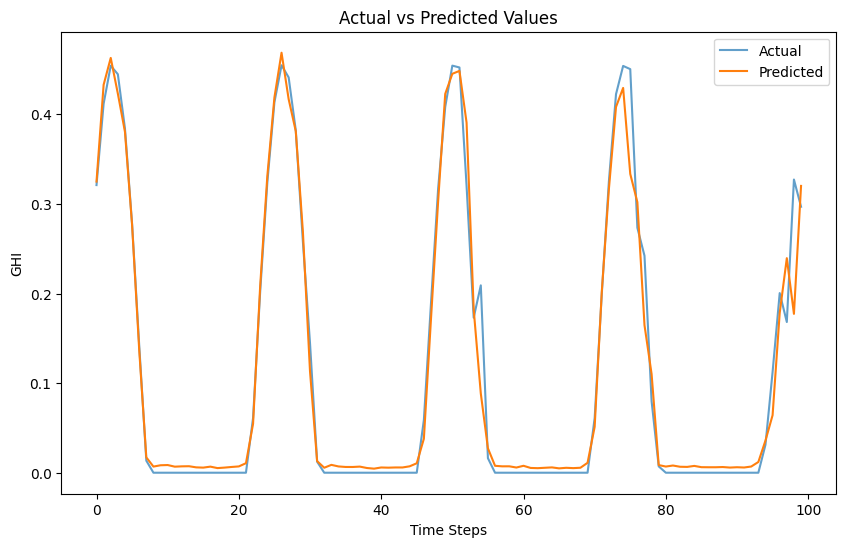

In [30]:
import matplotlib.pyplot as plt

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(Y_test[:100], label='Actual', alpha=0.7)  # First 100 samples
plt.plot(Y_pred[:100], label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('GHI')
plt.legend()
plt.show()

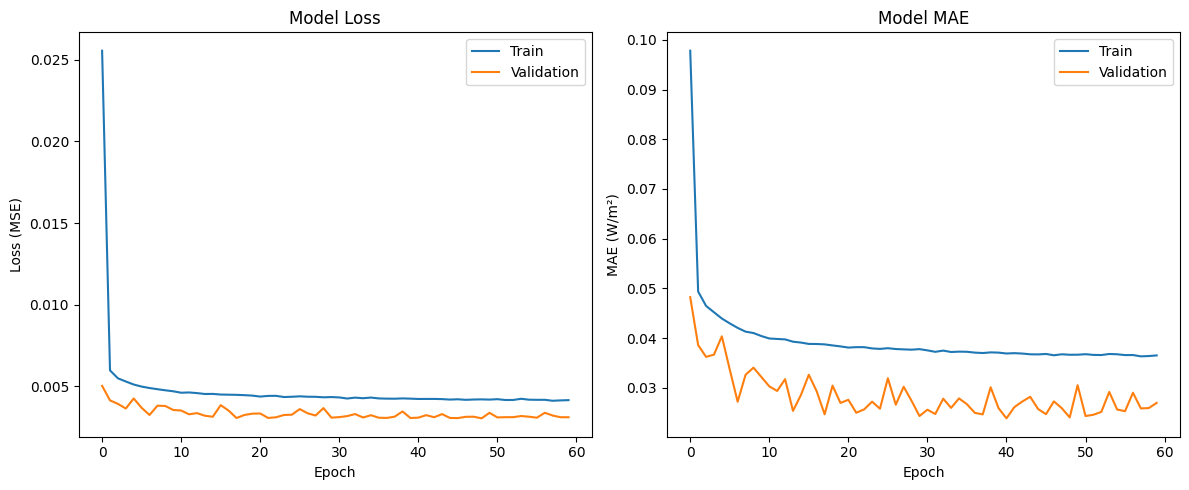

In [31]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title('Model MAE')
plt.ylabel('MAE (W/m²)')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()